# Pytorch开发深度学习模型一般步骤

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写



In [9]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as D
from torch import nn
import pandas as pd
import numpy as np
import copy
import os
from sklearn.metrics import roc_auc_score,log_loss
from tqdm import tqdm
from itertools import combinations

In [2]:
#参数配置

config = {
    "data_path":'criteo.csv',
    "sparse_cols":[f'C{x}' for x in range(1,27)],
    "dense_cols" : [f'I{x}' for x in range(1,14)],
    "train_ratio" : 0.7,
    "valid_ratio" : 0.2,
    "debug_mode" : True,
    "epoch" : 5,
    "batch" : 10240,
    "lr" : 0.0001,
    "device" : -1,
}

In [3]:
df = pd.read_csv(config['data_path'])

In [4]:
if config['debug_mode']:
    df = df[:1000]
df[config['sparse_cols']] = df[config['sparse_cols']].fillna('-1', )
df[config['dense_cols']] = df[config['dense_cols']].fillna(0, )
train_num = int(len(df)*config['train_ratio'])
valid_num = int(len(df)*config['valid_ratio'])
#切分数据集
train_df = df[:train_num].reset_index(drop=True)
valid_df = df[train_num:train_num+valid_num].reset_index(drop=True)
test_df = df[train_num+valid_num:].reset_index(drop=True)

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O




In [5]:
#Dataset构造
class BaseDataset(Dataset):
    def __init__(self,config,df,enc_dict=None):
        self.config = config
        self.df = df
        self.enc_dict = enc_dict
        self.dense_cols = list(set(self.config['dense_cols']))
        self.sparse_cols = list(set(self.config['sparse_cols']))
        self.feature_name = self.dense_cols+self.sparse_cols+['label']

        #数据编码
        if self.enc_dict == None:
            self.get_enc_dict()
        self.enc_data()

    def get_enc_dict(self):
        #计算enc_dict
        self.enc_dict = dict(zip( list(self.dense_cols+self.sparse_cols),[dict() for _ in range(len(self.dense_cols+self.sparse_cols))]))
        for f in self.sparse_cols:
            self.df[f] = self.df[f].astype('str')
            map_dict = dict(zip(self.df[f].unique(), range(1,self.df[f].nunique()+1)))
            self.enc_dict[f] = map_dict
            self.enc_dict[f]['vocab_size'] = self.df[f].nunique()+1
            '''
            eg:C17 特征的map_dict
            {'e5ba7672': 1,
             '07c540c4': 2,
             '8efede7f': 3,
             '1e88c74f': 4,
             '776ce399': 5,
             'd4bb7bd8': 6,
             '3486227d': 7,
             '27c07bd6': 8,
             '2005abd1': 9,
             'vocab_size': 10}
            '''

        for f in self.dense_cols:
            self.enc_dict[f]['min'] = self.df[f].min()
            self.enc_dict[f]['max'] = self.df[f].max()
            '''
            eg:I6 特征
            {'min': 0.0, 'max': 4638.0}
            '''
        return self.enc_dict

    def enc_dense_data(self,col):
        return (self.df[col] - self.enc_dict[col]['min']) / (self.enc_dict[col]['max'] - self.enc_dict[col]['min'])

    def enc_sparse_data(self,col):
        return self.df[col].apply(lambda x : self.enc_dict[col].get(x,0))

    def enc_data(self):
        #使用enc_dict对数据进行编码
        self.enc_df = copy.deepcopy(self.df)
        for col in self.dense_cols:
            self.enc_df[col] = self.enc_dense_data(col)
        for col in self.sparse_cols:
            self.enc_df[col] = self.enc_sparse_data(col)

    def __getitem__(self, index):
        data = dict()
        for col in self.feature_name:
            if col in self.dense_cols:
                data[col] = torch.Tensor([self.enc_df[col].iloc[index]]).squeeze(-1)
            elif col in self.sparse_cols:
                data[col] = torch.Tensor([self.enc_df[col].iloc[index]]).long().squeeze(-1)
        data['label'] = torch.Tensor([self.enc_df['label'].iloc[index]]).squeeze(-1)
        return data

    def __len__(self):
        return len(self.enc_df)

In [6]:
train_dataset = BaseDataset(config,train_df)
enc_dict = train_dataset.get_enc_dict()

valid_dataset = BaseDataset(config,valid_df,enc_dict=enc_dict)
test_dataset = BaseDataset(config,test_df,enc_dict=enc_dict)

In [7]:
train_dataset.__getitem__(5)

{'I5': tensor(0.0144),
 'I13': tensor(0.),
 'I11': tensor(0.),
 'I8': tensor(0.),
 'I9': tensor(0.0011),
 'I2': tensor(0.),
 'I12': tensor(0.),
 'I1': tensor(0.),
 'I10': tensor(0.),
 'I6': tensor(0.),
 'I3': tensor(0.),
 'I4': tensor(0.),
 'I7': tensor(0.),
 'C13': tensor(6),
 'C20': tensor(3),
 'C14': tensor(3),
 'C2': tensor(6),
 'C23': tensor(3),
 'C1': tensor(4),
 'C5': tensor(2),
 'C19': tensor(2),
 'C6': tensor(4),
 'C17': tensor(5),
 'C4': tensor(6),
 'C24': tensor(6),
 'C7': tensor(6),
 'C11': tensor(6),
 'C3': tensor(6),
 'C25': tensor(2),
 'C21': tensor(6),
 'C22': tensor(3),
 'C9': tensor(1),
 'C18': tensor(6),
 'C8': tensor(2),
 'C12': tensor(6),
 'C15': tensor(6),
 'C10': tensor(3),
 'C26': tensor(3),
 'C16': tensor(6),
 'label': tensor(0.)}

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

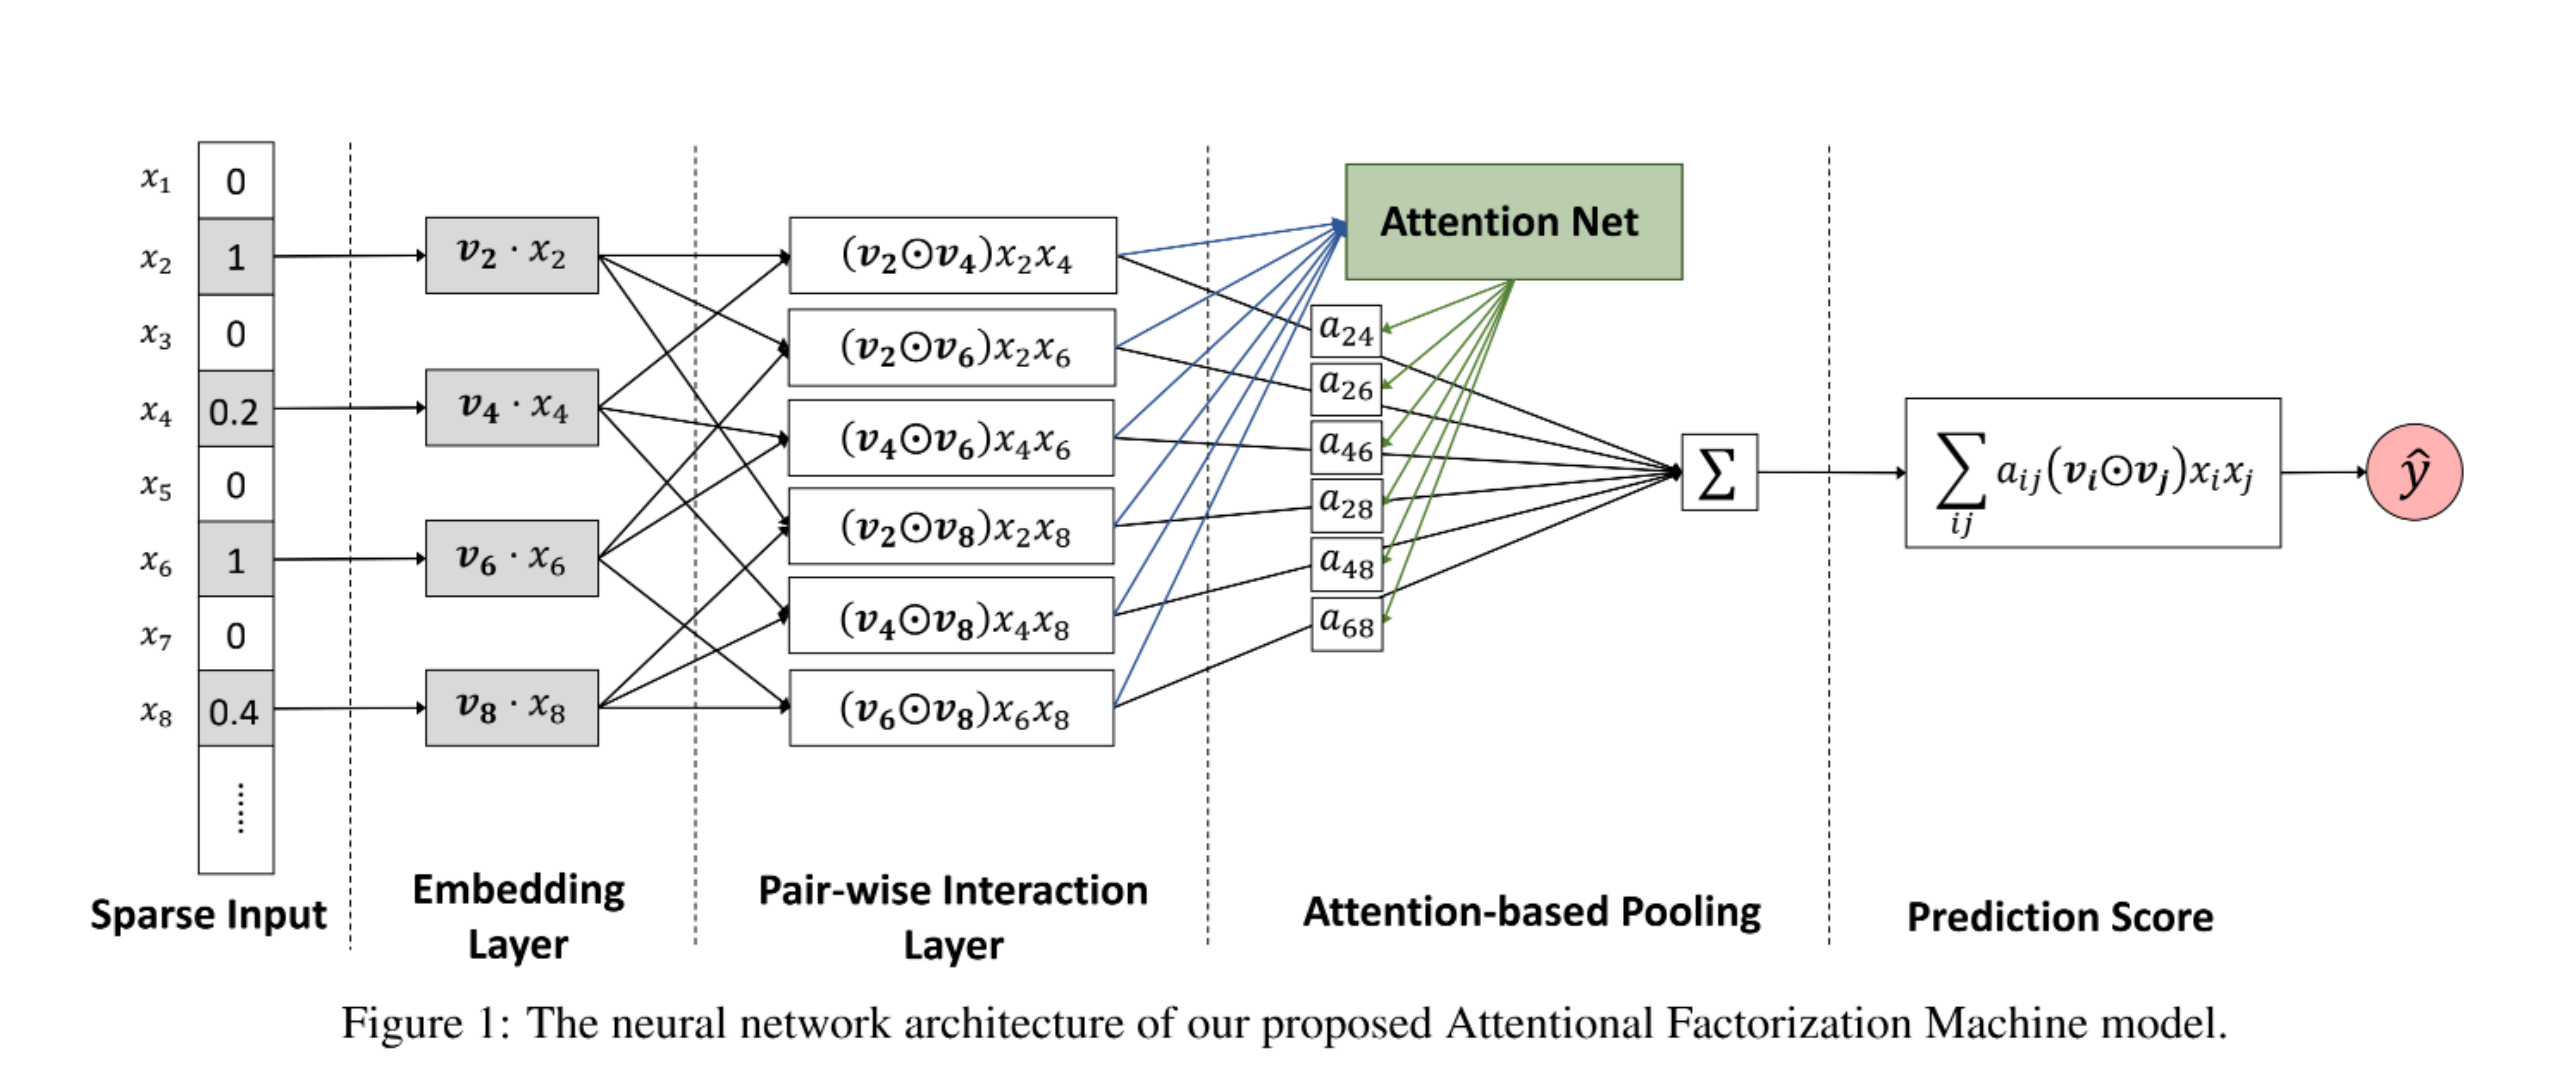

In [8]:
#基本网络模块

#通用Emb
class EmbeddingLayer(nn.Module):
    def __init__(self,
                 enc_dict = None,
                 embedding_dim = None):
        super(EmbeddingLayer, self).__init__()
        self.enc_dict = enc_dict
        self.embedding_dim = embedding_dim
        self.embedding_layer = nn.ModuleDict()

        self.emb_feature = []

        for col in self.enc_dict.keys():
            if 'vocab_size' in self.enc_dict[col].keys():
                self.emb_feature.append(col)
                self.embedding_layer.update({col : nn.Embedding(
                    self.enc_dict[col]['vocab_size'],
                    self.embedding_dim,
                )})

    def forward(self, X):
        #对所有的sparse特征挨个进行embedding
        feature_emb_list = []
        for col in self.emb_feature:
            inp = X[col].long().view(-1, 1)
            feature_emb_list.append(self.embedding_layer[col](inp))
        return feature_emb_list
    
#一阶交叉
class LR_Layer(nn.Module):
    def __init__(self,enc_dict):
        super(LR_Layer, self).__init__()
        self.enc_dict = enc_dict
        self.emb_layer = EmbeddingLayer(enc_dict=self.enc_dict,embedding_dim=1)
        self.dnn_input_dim = get_dnn_input_dim(self.enc_dict, 1)
        self.fc = nn.Linear(self.dnn_input_dim,1)
        
    def forward(self,data):
        sparse_emb = self.emb_layer(data)
        sparse_emb = torch.stack(sparse_emb,dim=1).flatten(1) #[batch,num_sparse*emb]
        dense_input = get_linear_input(self.enc_dict, data)  #[batch,num_dense]
        dnn_input = torch.cat((sparse_emb, dense_input), dim=1) # [batch,num_sparse*emb + num_dense]
        out = self.fc(dnn_input)
        return out
    

# Overfitting Prevention
## Dropout
为了避免过拟合，在pair-wise interactions后接入dropout，通过随机dropout掉一些特征对，来提高模型的泛化能力
## L2 regularization
对计算Attention Score的W进行正则化

In [51]:
#FM层
class FMPlus(nn.Module):
    def __init__(self, embedding_dim = 32, attention_factor = 32, dropout_rate=0):
        super(FMPlus, self).__init__()
        self.attention_factor = attention_factor
        self.embedding_dim = embedding_dim
        self.dropout_rate = dropout_rate
        self.attention_net = nn.Sequential(
                       nn.Linear(self.embedding_dim, self.attention_factor),
                       nn.ReLU(),
                       nn.Linear(self.attention_factor, 1, bias=False),
                       nn.Softmax(dim=1)
                    )
        if self.dropout_rate >0:
            self.dropout = nn.Dropout(self.dropout_rate)
    
    def forward(self, feature_emb_list):
        pair_feature = []
        for vi,vj in combinations(feature_emb_list, 2):
            pair_feature.append(vi*vj)
        pair_feature = torch.cat(pair_feature,dim=1) #[batch,num_pair:<(n-1)*n/2>,emb]
        attention_weight = self.attention_net(pair_feature) #[batch,num_pair,1]
        if self.dropout_rate>0:
            attention_weight = self.dropout(attention_weight)
        pair_feature = torch.sum(pair_feature * attention_weight,dim=1) #[batch,emb]
        pair_feature = torch.sum(pair_feature,dim=-1).unsqueeze(-1) #[batch,1]

        return pair_feature
    
#DNN
class MLP_Layer(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=None,
                 hidden_units=[],
                 hidden_activations="ReLU",
                 final_activation=None,
                 dropout_rates=0,
                 batch_norm=False,
                 use_bias=True):
        super(MLP_Layer, self).__init__()
        dense_layers = []
        if not isinstance(dropout_rates, list):
            dropout_rates = [dropout_rates] * len(hidden_units)
        if not isinstance(hidden_activations, list):
            hidden_activations = [hidden_activations] * len(hidden_units)
        hidden_activations = [set_activation(x) for x in hidden_activations]
        hidden_units = [input_dim] + hidden_units
        for idx in range(len(hidden_units) - 1):
            dense_layers.append(nn.Linear(hidden_units[idx], hidden_units[idx + 1], bias=use_bias))
            if batch_norm:
                dense_layers.append(nn.BatchNorm1d(hidden_units[idx + 1]))
            if hidden_activations[idx]:
                dense_layers.append(hidden_activations[idx])
            if dropout_rates[idx] > 0:
                dense_layers.append(nn.Dropout(p=dropout_rates[idx]))
        if output_dim is not None:
            dense_layers.append(nn.Linear(hidden_units[-1], output_dim, bias=use_bias))
        if final_activation is not None:
            dense_layers.append(set_activation(final_activation))
        self.dnn = nn.Sequential(*dense_layers)  # * used to unpack list

    def forward(self, inputs):
        return self.dnn(inputs)

def set_device(gpu=-1):
    if gpu >= 0 and torch.cuda.is_available():
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
        device = torch.device(f"cuda:{gpu}")
    else:
        device = torch.device("cpu")
    return device
    
def set_activation(activation):
    if isinstance(activation, str):
        if activation.lower() == "relu":
            return nn.ReLU()
        elif activation.lower() == "sigmoid":
            return nn.Sigmoid()
        elif activation.lower() == "tanh":
            return nn.Tanh()
        else:
            return getattr(nn, activation)()
    else:
        return activation
    
def get_dnn_input_dim(enc_dict,embedding_dim):
    num_sparse = 0
    num_dense = 0
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            num_dense+=1
        elif 'vocab_size' in enc_dict[col].keys():
            num_sparse+=1
    return num_sparse*embedding_dim+num_dense

def get_linear_input(enc_dict,data):
    res_data = []
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            res_data.append(data[col])
    res_data = torch.stack(res_data,axis=1)
    return res_data

In [67]:
#AFM 模型
class AFM(nn.Module):
    def __init__(self,
                 embedding_dim=10,
                 attention_factor = 32,
                 dropout_rate = 0,
                 l2_reg = 0.1,
                 loss_fun = 'torch.nn.BCELoss()',
                 enc_dict=None):
        super(AFM, self).__init__()

        self.embedding_dim = embedding_dim
        self.attention_factor = attention_factor
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.loss_fun = eval(loss_fun)
        self.enc_dict = enc_dict

        self.embedding_layer = EmbeddingLayer(enc_dict=self.enc_dict, embedding_dim=self.embedding_dim)
        
        self.fm = FMPlus(embedding_dim=embedding_dim,
                        attention_factor=attention_factor,
                        dropout_rate=dropout_rate) #二阶
        self.lr = LR_Layer(enc_dict=enc_dict) #一阶
        # TODO 实现一个比较通用的计算正则化的代码
#         self.add_reg(self.fm.attention_net[0].weight)
    
#     def add_reg(self,weight):
#         self.reg_list.append(weight)
    
#     def get_l1_loss(self):
#         l1_loss = 0
#         for weight in self.reg_list:
#             l1_loss += torch.sum(self.l1_reg * torch.abs(weight))
#         return l1_loss
    
#     def get_l2_loss(self):
#         l2_loss = 0
#         for weight in self.reg_list:
#             l2_loss += torch.sum(self.l1_reg * weight**2)
#         return l2_loss
#     def get_reg_loss(self):
#         l1_loss = 0
#         l2_loss = 0
#         if self.l1:
#             l1_loss = self.get_l1_loss()
#         if self.l2:
#             l2_loss = self.get_l2_loss()
#         reg_loss = l1_loss+l2_loss
#         return reg_loss
    
    def get_l2_reg_loss(self,):
        attention_W = self.fm.attention_net[0].weight
        reg_loss = torch.sum(self.l2_reg * attention_W**2)
        return reg_loss

    def forward(self, data):
        sparse_embedding = self.embedding_layer(data)
        
        # FM
        lr_logit = self.lr(data) #一阶交叉
        fm_logit = self.fm(sparse_embedding) #二阶交叉
        
        #输出
        y_pred = torch.sigmoid(lr_logit + fm_logit)
        loss = self.loss_fun(y_pred.squeeze(-1),data['label'])
        loss += self.get_l2_reg_loss()
        output_dict = {'pred':y_pred,'loss':loss}
        return output_dict

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写

In [68]:
#训练模型，验证模型
def train_model(model, train_loader, optimizer, device, metric_list=['roc_auc_score','log_loss']):
    model.train()
    pred_list = []
    label_list = []
    pbar = tqdm(train_loader)
    for data in pbar:

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']
        loss = output['loss']

        loss.backward()
        optimizer.step()
        model.zero_grad()

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())
        pbar.set_description("Loss {}".format(loss))

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def valid_model(model, valid_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (valid_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def test_model(model, test_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (test_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze().cpu().detach().numpy())
        label_list.extend(data['label'].squeeze().cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

In [69]:
#dataloader
train_loader = D.DataLoader(train_dataset,batch_size=config['batch'],shuffle=True,num_workers=0)
valid_loader = D.DataLoader(valid_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)
test_loader = D.DataLoader(test_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)

In [70]:
model = AFM(enc_dict=enc_dict)

In [71]:
device = set_device(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
model = model.to(device)
#模型训练流程
for i in range(config['epoch']):
    #模型训练
    train_metirc = train_model(model,train_loader,optimizer=optimizer,device=device)
    #模型验证
    valid_metric = valid_model(model,valid_loader,device)

    print("Train Metric:")
    print(train_metirc)
    print("Valid Metric:")
    print(valid_metric)
#测试模型
test_metric = test_model(model,test_loader,device)
print('Test Metric:')
print(test_metric)

Loss 1.8548346757888794: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Train Metric:
{'roc_auc_score': 0.45632823191171484, 'log_loss': 0.7940654622018337}
Valid Metric:
{'roc_auc_score': 0.4563600072582109, 'log_loss': 0.7935155886411667}


Loss 1.8529446125030518: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Train Metric:
{'roc_auc_score': 0.4565667725452286, 'log_loss': 0.7930601427597659}
Valid Metric:
{'roc_auc_score': 0.4563600072582109, 'log_loss': 0.7924110576510429}


Loss 1.8510572910308838: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Train Metric:
{'roc_auc_score': 0.4568053131787423, 'log_loss': 0.7920569793454239}
Valid Metric:
{'roc_auc_score': 0.4563600072582109, 'log_loss': 0.7913091658055782}


Loss 1.849172592163086: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Train Metric:
{'roc_auc_score': 0.4571442919737354, 'log_loss': 0.7910560250708035}
Valid Metric:
{'roc_auc_score': 0.4563600072582109, 'log_loss': 0.7902098728716374}


Loss 1.8472907543182373: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]

Train Metric:
{'roc_auc_score': 0.45747071599854366, 'log_loss': 0.7900573381781578}
Valid Metric:
{'roc_auc_score': 0.45654146252948646, 'log_loss': 0.7891134725511074}
Test Metric:
{'roc_auc_score': 0.43710539096648865, 'log_loss': 0.795752359032631}


In [85]:
model.fm.attention_net[0].weight

Parameter containing:
tensor([[ 2.2541e-01,  2.9293e-02,  2.6197e-01,  3.1058e-01, -2.5464e-01,
          2.3129e-01,  6.6727e-02, -1.6519e-01, -2.3175e-01,  1.9846e-01],
        [ 5.7171e-02,  3.0148e-01, -2.5248e-01, -1.1321e-01,  1.5692e-01,
          1.6234e-02,  9.0751e-02,  1.9061e-01,  6.6472e-02,  1.6707e-01],
        [ 1.1593e-01,  3.1310e-02,  2.2454e-01, -1.5563e-02,  6.7147e-02,
         -1.1579e-01,  4.6118e-02,  3.6503e-02, -2.9428e-01, -3.4016e-02],
        [ 3.0961e-01, -4.6523e-02, -3.9151e-02, -2.9092e-01,  1.6249e-01,
          1.8415e-01, -2.8984e-01,  2.2284e-01, -2.0268e-01, -7.9656e-02],
        [ 8.6662e-02,  3.1489e-01, -5.9187e-02,  2.0875e-01,  2.8811e-01,
         -1.3286e-02, -2.8345e-01, -4.9606e-02, -1.0792e-01,  4.2269e-02],
        [ 3.2118e-02, -2.1181e-01,  1.4520e-01,  1.8219e-01, -7.1380e-02,
         -2.3681e-01, -1.9078e-01, -2.5731e-01, -2.0775e-01, -1.8467e-01],
        [-1.8077e-01, -1.0529e-01,  8.5916e-02, -2.0667e-01,  1.6001e-02,
          

In [93]:
feature_emb = torch.rand(16,6,4)
index_list = torch.from_numpy(np.array([1,1,2,2,2,2]))
s = torch.index_select(feature_emb, 1, index_list) 

In [94]:
feature_emb[:,1,:]

tensor([[0.2366, 0.6792, 0.9827, 0.9470],
        [0.6979, 0.3218, 0.1581, 0.1832],
        [0.2183, 0.5622, 0.4218, 0.8454],
        [0.5407, 0.1057, 0.2991, 0.3788],
        [0.0693, 0.0240, 0.5880, 0.4556],
        [0.5691, 0.9805, 0.8725, 0.9484],
        [0.8959, 0.3479, 0.6994, 0.2902],
        [0.9033, 0.8003, 0.8317, 0.4483],
        [0.6657, 0.3606, 0.9811, 0.8740],
        [0.6480, 0.9751, 0.0559, 0.1586],
        [0.2981, 0.9037, 0.2337, 0.4048],
        [0.6637, 0.0766, 0.6639, 0.3287],
        [0.1452, 0.2781, 0.2262, 0.8688],
        [0.8317, 0.4312, 0.2104, 0.8584],
        [0.2442, 0.7331, 0.8512, 0.1274],
        [0.4274, 0.5121, 0.5327, 0.5312]])

In [96]:
s[:,1,:]

tensor([[0.2366, 0.6792, 0.9827, 0.9470],
        [0.6979, 0.3218, 0.1581, 0.1832],
        [0.2183, 0.5622, 0.4218, 0.8454],
        [0.5407, 0.1057, 0.2991, 0.3788],
        [0.0693, 0.0240, 0.5880, 0.4556],
        [0.5691, 0.9805, 0.8725, 0.9484],
        [0.8959, 0.3479, 0.6994, 0.2902],
        [0.9033, 0.8003, 0.8317, 0.4483],
        [0.6657, 0.3606, 0.9811, 0.8740],
        [0.6480, 0.9751, 0.0559, 0.1586],
        [0.2981, 0.9037, 0.2337, 0.4048],
        [0.6637, 0.0766, 0.6639, 0.3287],
        [0.1452, 0.2781, 0.2262, 0.8688],
        [0.8317, 0.4312, 0.2104, 0.8584],
        [0.2442, 0.7331, 0.8512, 0.1274],
        [0.4274, 0.5121, 0.5327, 0.5312]])